# Bus Parameter Validation

In this notebook we validate the electric bus parameters we'll input to FASTSim. This must be done before we can trust our FASTSim CDMX bus route simulation outputs.

We don't have a lot of great options to validate our simulation output against experimental results, so we'll compare our simulation results to the simulation results from the 2021 LOGIOS study of electrifying bus routes in Mexicali.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
from fastsim import simdrive, vehicle, cycle
import utils
utils.run_tests()

## The hybrid Yutong/Logios Bus Parameters

In [3]:
# Highlight the parameter differences between the yutong bus parameters and the newer 
# parameters we're using to approximate the buses used by LOGIOS in their report.
vehicles_df = pd.read_csv(Path('./bus.csv'))
yutong = vehicles_df.iloc[0]
logios = vehicles_df.iloc[1]
diff_cols = []
for i in range(len(yutong)):
    if (yutong[i] != logios[i]) and not pd.isnull(yutong[i]):
        diff_cols.append(yutong.index[i])
vehicles_df.filter(diff_cols)

,Selection,Scenario name,frontalAreaM2,gliderKg,cargoKg,maxMotorKw,maxEssKwh,minSoc,maxSoc,auxKw
0,1,Yutong,7.46,10000,5000,350,295,10%,90%,10
1,2,LOGIOS/Yutong,8.50,14050,3600,300,325,0%,100%,6


In [4]:
bus = vehicle.Vehicle(2, veh_file=Path('./bus.csv'))
bus_jit = bus.get_numba_veh()

## The LOGIOS drive cycle

Route AB03, recorded on 5/20/21.

Processing route AB03, day 0520...
Time to run simulation: 1.04e+00 s
Processing route AB03, day 0521...
Time to run simulation: 9.71e-01 s
Processing route AB03, day 0527...
Time to run simulation: 9.16e-01 s
Processing route AB03, day 0531...
Time to run simulation: 7.58e-01 s
Processing route TC08, day 0525...
Time to run simulation: 9.57e-01 s


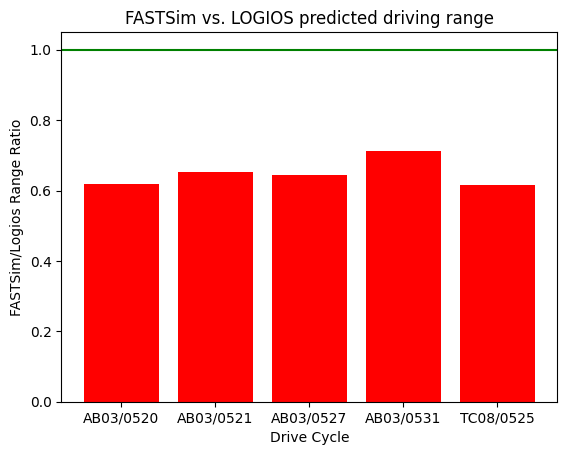

On average, of the 5 simulated drive cycles, FASTSim's simulated range is 64.89% of LOGIOS's


In [17]:
INPUT_PATH = '../Data/LOGIOS Data/Drive Cycles'
routes_and_days = {
    'AB03': {
        # Days when drive cycle data was collected
        'days': ['0520', '0521', '0527', '0531'],
        
        # LOGIOS-predicted range along this route from 100% to 0% SOC
        'rangeKm': 220,
    },
    'TC08': {
        'days': ['0525'], 
        'rangeKm': 244,
    }
}

route_days = []
range_diffs = []
for route_name in routes_and_days.keys():
    route = routes_and_days[route_name]
    for day in route['days']:
        print(f'Processing route {route_name}, day {day}...')
        drive_cycle_path = Path(INPUT_PATH) / route_name / day
        output = utils.run_fastsim(drive_cycle_path, bus_jit)
        fastsim_range = output['rangeKm']
        logios_range = route['rangeKm']
        route_days.append((f'{route_name}/{day}'))
        range_diffs.append(fastsim_range/logios_range)

plt.bar(route_days, height=range_diffs, color='red')
plt.title('FASTSim vs. LOGIOS predicted driving range');
plt.axhline(1.0, color='green')
plt.xlabel('Drive Cycle');
plt.ylabel('FASTSim/Logios Range Ratio');
plt.show()

print(f'On average, of the {len(route_days)} simulated drive cycles, FASTSim\'s simulated range is {np.average(range_diffs)*100:.01f}% of LOGIOS\'s')

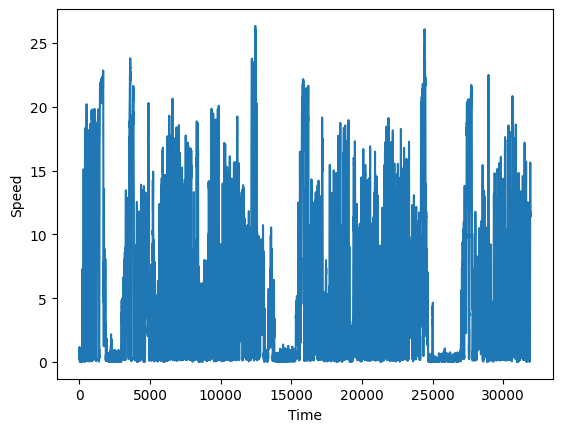

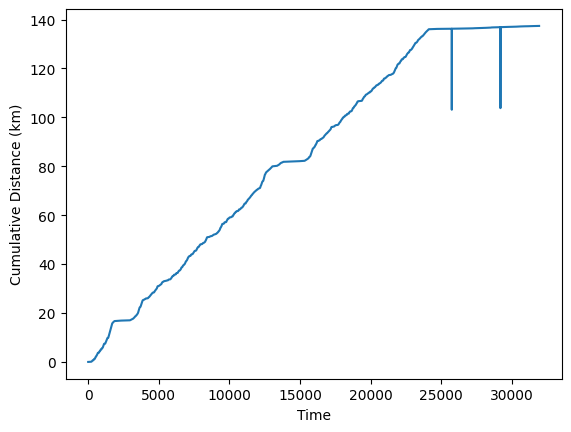

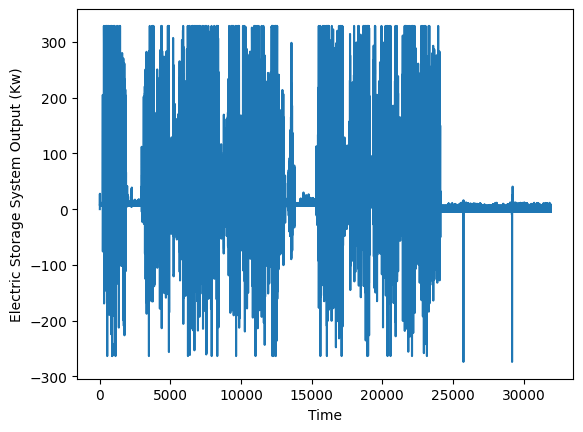

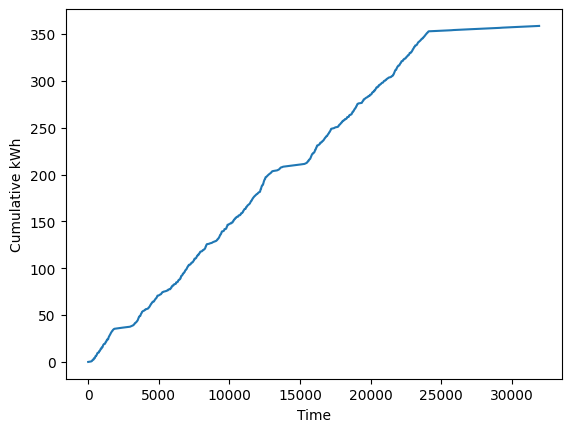

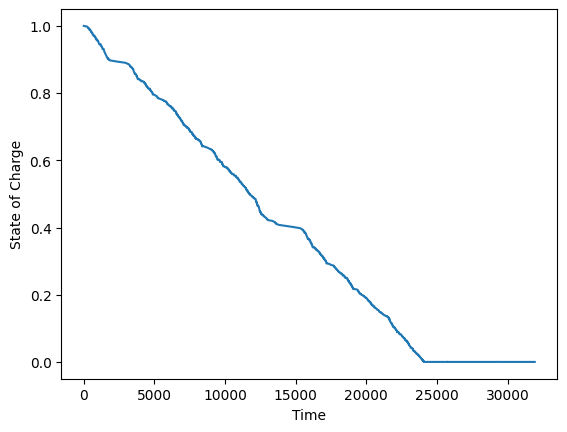

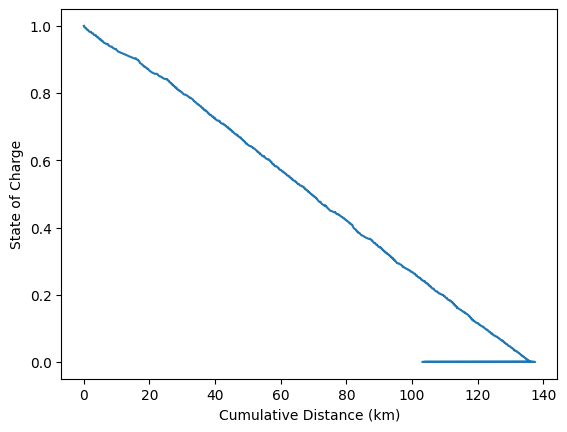

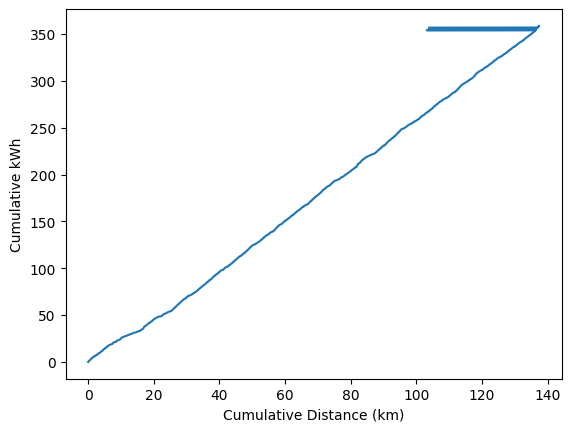

In [6]:
# Visualize
df = pd.DataFrame.from_dict(output)

# plt.rcParams['figure.figsize'] = [30, 20]

plt.plot(df['time'],df['speed'])
plt.xlabel('Time')
plt.ylabel('Speed')
plt.show()

plt.plot(df['time'],df['cumDistKm'])
plt.xlabel('Time')
plt.ylabel('Cumulative Distance (km)')
plt.show()

plt.plot(df['time'], df['essKwOutAch'])
plt.xlabel('Time')
plt.ylabel('Electric Storage System Output (Kw)')
plt.show()

plt.plot(df['time'], df['cumKwh'])
plt.xlabel('Time')
plt.ylabel('Cumulative kWh')
plt.show()

plt.plot(df['time'],df['soc'])
plt.xlabel('Time')
plt.ylabel('State of Charge')
plt.show()

plt.plot(df['cumDistKm'],df['soc'])
plt.xlabel('Cumulative Distance (km)')
plt.ylabel('State of Charge')
plt.show()

plt.plot(df['cumDistKm'], df['cumKwh'])
plt.xlabel('Cumulative Distance (km)')
plt.ylabel('Cumulative kWh')
plt.show()

In [11]:
print('Simulation summary:')
print(f'Final S.O.C.: {output["final_soc"]*100:.2f} %')
print(f'Distance driven: {output["distance_mi"]:.2f} miles. {output["distance_mi"]*utils.km_per_mile:.2f} km')
print(f'Total time driven: {df["time"].iloc[-1] * 1/3600:.2f} hours')
print(f'Total energy required: {df["cumKwh"].iloc[-1]:.2f} kWh')
# TODO: How can the cumulative kwh exceed the max capacity of the battery?

Simulation summary:
Final S.O.C.: -0.00 %
Distance driven: 85.39 miles. 137.42 km
Total time driven: 8.87 hours
Total energy required: 358.71 kWh
